In [1]:
import sys 
sys.path.append("/home/karen/Documents/GitHub/Muscle_wasting/network")
sys.path.append("/home/karen/Documents/GitHub/Muscle_wasting/database_analysis")
sys.path.append("/home/karen/Documents/GitHub/Muscle_wasting/venv/lib/python3.10/site-packages")
sys.path.append("/home/karen/Documents/GitHub/Muscle_wasting/venv/lib/python3.10/site-packages/networkx")

In [2]:
cd /home/karen/Documents/GitHub/Muscle_wasting

/home/karen/Documents/GitHub/Muscle_wasting


# Analyzing the relevance of the mirnas

Hello Kasia and Pilib, here is my report of the microRNAs


Now we saw with the filtered and whole network
Let's get the mirnas from the relevant PR score and then evaluate them on the whole network

## Background

There are 3 main steps relevant for this report
- DE data
- Network (Transcripor factors)
- Pathways


### DE data
I joined the different rnaseq expression data and using dseq2 got the differentially expressed data. Is important to mention that the DE genes are different than the ones obteined doing the experiments individually (really small overlap). 
We had the comparisons
    - Young vs Old
    - Young vs Middle Age
    - Middle Age vs Old
Therefore is always younger vs older, therefore, up regulared means that it decreases with age, and downregulated that increases with age.

### Network
Using the DE genes, was possible to identify the enriched TF using collectri database and the decoupler library function run_ulm. Using the same database, is possible to build the full network of gene-TF interactions. 
Additionally, using my network, I added the microRNAs as well.

### Pathways
Using msigdb we assigned to each gene the pathways they are involved. We only considered the pathays that were at least slightly enriched. From all the pathways, on this notebook, only the pathways that seem logically involved on sarcopenia are presented:

    - ATP 	
    - MITOCHONDRI 	
    - RESPIRAT 	
    - METABOLI 	
    - OXIDATIVE_PHOSPHORYLATION 	
    - NONALCOHOLIC_FATTY_LIVER 	
    - MUSCLE 	
    - ELECTRON
    
Now, as you can see, the name of the pathways are not compleate, this is because as microcondri I want to include terms as

    - GOBP_MITOCHONDRIAL_ELECTRON_TRANSPORT_NADH_TO_UBIQUINONE
    - GOCC_INNER_MITOCHONDRIAL_MEMBRANE_PROTEIN_COMPLEX
    - HP_ABNORMAL_MITOCHONDRIA_IN_MUSCLE_TISSUE
    - etc
    
All the pathways were added on the network with my software


Now that we have the data about the network, let's see the impact of the microRNAs

In [3]:
import walking_network as wn

In [4]:
import networkx as nx

In [5]:
import pandas as pd
import numpy as np

In [6]:
import matplotlib.pyplot as plt

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.colors as mcolors


In [8]:
# Function to ensure all elements are integers

def get_impact_data(df):
    def convert_to_int_list(lst):
        if isinstance(lst, list):
            return [int(x) for x in lst]
        else:
            return []
    color_data = pd.DataFrame(index=df.index, columns=df.columns)
    
    for col in df.columns:
        for idx in df.index:
            int_list = convert_to_int_list(df.at[idx, col])
            color_data.at[idx, col] = sum(int_list)

    return color_data


def plot_dotplot(df):
    def convert_to_int_list(lst):
        if isinstance(lst, list):
            return [int(x) for x in lst]
        else:
            return []


    
    # Create new DataFrame for plotting
    plot_data = pd.DataFrame(index=df.index, columns=df.columns)
    size_data = pd.DataFrame(index=df.index, columns=df.columns)
    color_data = pd.DataFrame(index=df.index, columns=df.columns)
    
    for col in df.columns:
        for idx in df.index:
            int_list = convert_to_int_list(df.at[idx, col])
            size_data.at[idx, col] = len(int_list)
            color_data.at[idx, col] = sum(int_list)
    
    # Convert to long format for seaborn
    plot_data = pd.DataFrame({
        'Gene': np.repeat(df.index, df.shape[1]),
        'miRNA': np.tile(df.columns, df.shape[0]),
        'Paths': size_data.values.flatten(),
        'Influence': color_data.values.flatten()
    })
    
    # Define custom colormap
    cmap = LinearSegmentedColormap.from_list('custom', ['red', 'white', 'blue'])

    
    
    # Filter out rows where the size is 0
    plot_data = plot_data[plot_data['Paths'] > 0]

    colors = ['red', 'white', 'blue']
    n_mid = abs(min(plot_data['Influence'])) / (abs(min(plot_data['Influence'])) + max(plot_data['Influence']))
    nodes = [0, n_mid, 1]
    cmap = LinearSegmentedColormap.from_list('custom', list(zip(nodes, colors)))
    
    # Plot using seaborn
    n_mirna= len(size_data.columns) + 1
    n_genes  = len(size_data) + 1
    print('genes', n_genes - 1)
    print('mirnas', n_mirna - 1)
    height_plot = min(655,int(n_genes*.3))

    height_plot = max(10, height_plot)
    sns.set(rc={'axes.facecolor':'lightgray'})
    fig, ax = plt.subplots(figsize=(n_mirna*1.5, height_plot))
    ax.grid(False)


    
    #plt.figure(figsize=(10, height_plot))
    scatter_plot = sns.scatterplot(data=plot_data, x='miRNA', y='Gene', size='Paths', hue='Influence', palette=cmap, sizes=(20, 200))
    scatter_plot.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

    
    # Get the first two and last y-tick positions.
    miny, nexty, *_, maxy = ax.get_yticks()
    
    # Compute half the y-tick interval (for example).
    eps = (nexty - miny) / 2  # <-- Your choice.
    plt.xticks(rotation=90)
    # Adjust the limits.
    ax.set_ylim(maxy+eps, miny-eps)
    #plt.tight_layout()
    plt.show()

In [9]:

def order_length_mirna(df, interest_mirna:str):
    df_sorted = df.copy()
    df_sorted['length'] = df_sorted[interest_mirna].apply(lambda x: len(x) if isinstance(x, list) else 0)
    df_sorted = df_sorted.sort_values(by='length', ascending=False)
    df_sorted = df_sorted.drop(columns=['length'])
    return df_sorted


def order_impact_mirna(df, interest_mirna:str):
    df_sorted = df.copy()
    df_sorted['impact'] = df_sorted[interest_mirna].apply(lambda x: sum(x) if isinstance(x, list) else 0)
    df_sorted = df_sorted.sort_values(by='impact', ascending=False)
    df_sorted = df_sorted.drop(columns=['impact'])
    return df_sorted

We used 2 netwoks here, the original one of 4159 nodes and 14587 edges with all the genes, TF and microRNAs generated, and the second one that is the same network but only the nodes whitin the top 80% of nodes of the pageRank rank. This limit was done given the fact that with that small theshold, from 566 mirnas to 13 mirnas.

In [10]:
whole_network = nx.read_gpickle(f"network/Networks_pkl/pathway_n_tf_mirnas__tf_network_cutoff_0.pkl")

In [11]:
pr_network = nx.read_gpickle(f"network/Networks_pkl/pathway_n_tf_mirnas__tf_network_cutoff_0.1.pkl")

In [12]:
steps=5

In [13]:
miR_nodes = [node for node in pr_network.nodes if node.startswith('hsa-miR')]


In [14]:
len(miR_nodes)

566

## MicroRNAs influence on genes

Starting on each of those 13 mirnas, we cover all the accesible paths from that node (each edge visited only once), if the influence is inhibition, it applies a -1, if it is activation, +1. Doing that, we can register in each time the mirna visitis a particular gene, see if the mirna has a positive or negative interaction.
Each node has a list of (1,-1), the length of the list means the amount of times the mirna is able to reach the node.
For each mirna, you can see the impact on each gene and looks like this:

In [15]:

for mir in miR_nodes:
    try:
        wn.start_mir_path(whole_network, mir)
    except KeyError as ke:
        print(ke)


In [16]:
wn.start_mir_path(whole_network, 'hsa-miR-145-5p')

In [17]:
influences={}
for node_name in whole_network.nodes:
    node = whole_network.nodes[node_name]
    if 'influence' in node['data']:
        influence = node['data']['influence']
        if type(influence)== dict and 'hsa-' not in node['data']['name']:
            influences[node['data']['name']]=influence


In [18]:
df = pd.DataFrame(influences)

In [19]:
df = df[df.index.isin(miR_nodes)]
df = df.fillna("").apply(list)
df[['MYC', 'TERT', 'SPI1','BGLAP','IL2', 'SMAD7', 'E2F3']]

,MYC,TERT,SPI1,BGLAP,IL2,SMAD7,E2F3
hsa-miR-21-5p,"[-1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1...","[-1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1...","[-1, -1, 1]","[1, 1, 1, -1, -1, 1, -1, -1]","[-1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, ...","[1, 1, 1, 1, 1, 1, -1]","[1, 1, -1, 1, 1, 1, -1]"
hsa-miR-210-3p,"[-1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1,...","[-1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1,...","[-1, -1, 1]","[-1, 1, 1, -1, 1, 1, -1, -1]","[-1, -1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, ...","[1, 1, 1, 1, 1, 1, -1]","[-1, -1, -1, -1, 1, 1, -1]"
hsa-miR-145-5p,"[-1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1,...","[-1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1...","[-1, -1, -1, -1, -1, -1]","[1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, ...","[-1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1]"
hsa-miR-143-3p,"[-1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, ...","[-1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1...","[-1, -1, -1]","[1, 1, -1, -1, 1, 1, -1, -1]","[-1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1]","[-1, -1, -1, -1, -1, -1, -1]","[1, 1, -1, 1, -1, 1, -1]"
hsa-miR-128-3p,"[-1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1,...","[-1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1,...","[-1, -1, 1]","[-1, 1, 1, -1, 1, 1, -1, -1]","[-1, -1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, ...","[1, 1, 1, 1, 1, 1, -1]","[-1, -1, -1, -1, 1, -1, 1, -1]"
...,...,...,...,...,...,...,...
hsa-miR-584-5p,,,,,,,
hsa-miR-1280,,,,,,,
hsa-miR-584-3p,,,,,,,
hsa-miR-1180-3p,,,,,,,


In [20]:
df.to_csv(f"mirna_influence_{len(miR_nodes)}_genes.csv")

In [21]:
# Function to calculate the sum of lengths of lists in a row
def sum_lengths(row):
    return sum(len(lst) for lst in row)

# Add the new column 'X'
df['final']=df.apply(sum_lengths, axis=1)

In [22]:
desc = df['final'].describe()
desc

count      559.000000
mean      1953.563506
std       3892.324362
min          1.000000
25%          1.000000
50%          3.000000
75%         23.000000
max      19056.000000
Name: final, dtype: float64

In [23]:
desc

count      559.000000
mean      1953.563506
std       3892.324362
min          1.000000
25%          1.000000
50%          3.000000
75%         23.000000
max      19056.000000
Name: final, dtype: float64

<Axes: xlabel='final', ylabel='Count'>

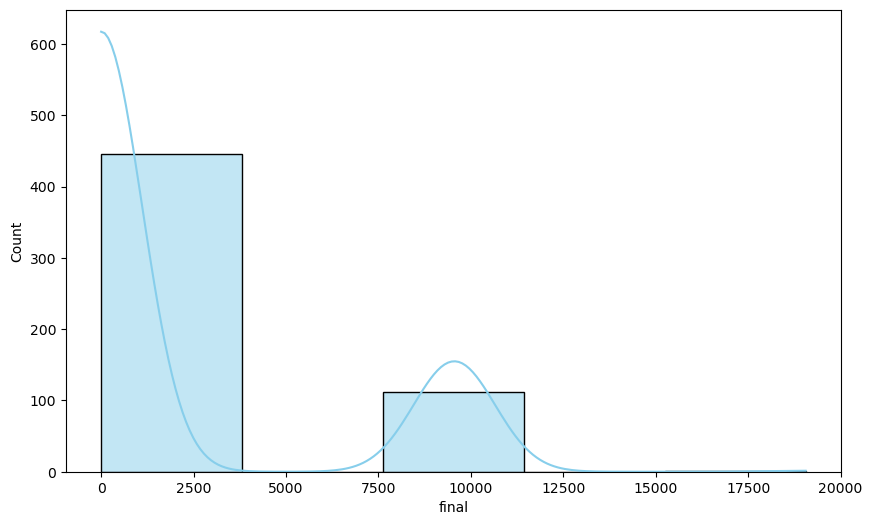

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(df['final'], kde=True, color='skyblue', bins=5)

In [25]:
df = df[df['final']>17]
len(df)

147

In [26]:
df.to_csv(f"mirna_influence_{len(df)}_genes_impact.csv")

In [27]:
#df = pd.read_csv(f"mirna_influence_147_genes_impact.csv", index_col=0)

In [28]:
test_mir= 'hsa-miR-1-3p'
test_mir='hsa-miR-200c-5p'
test_mir_df = df.T[test_mir]
test_mir_df  = pd.DataFrame(test_mir_df)
test_mir_df['length'] = test_mir_df[test_mir].apply(lambda x: len(x)  if isinstance(x, list) else 0)
test_mir_df = test_mir_df.sort_values(by='length', ascending=False)
test_mir_df = test_mir_df[test_mir_df['length']>5]
test_mir_df = test_mir_df.drop(columns=['length'])

test_mir_df


,hsa-miR-200c-5p
TNF,"[-1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1,..."
CDKN1A,"[-1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1..."
IL6,"[-1, 1, 1, -1, 1, -1, -1, -1, -1, 1, 1, 1, 1, ..."
SERPINE1,"[1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -..."
TP53,"[-1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1,..."
...,...
TIMP2,"[1, -1, 1, 1, 1, -1]"
KDM6B,"[1, -1, -1, -1, 1, 1]"
UBC,"[-1, 1, 1, 1, 1, 1]"
GJA1,"[-1, 1, -1, -1, 1, -1]"


In [29]:
len(df)

147

**interesting**,
hsa-miR-21-5p and hsa-miR-210-3p behaive really similar but is not the same, and hsa-miR-145-5p and hsa-miR-143-3p are similar too.
Interesting is that (hsa-miR-21-5p and hsa-miR-210-3p) and (hsa-miR-145-5p and hsa-miR-143-3p) behaive almost opposite!!!

In [30]:
df = df.T

We can then look the data as a dotplot, the size of the dot means the amount of different ways the mirna has to reach that gene, if it is red, is that that mirna inhibits, if it blue, it means that the mirna activates it.

If the circle is big, but the color is white-ish, that means that some paths ibhibits and other activate. 
This is the dotplot of the 12895 genes... yeah, I recommend just scroll until the next section.  (seriously, do cntl + f "next section")

genes 7
mirnas 10


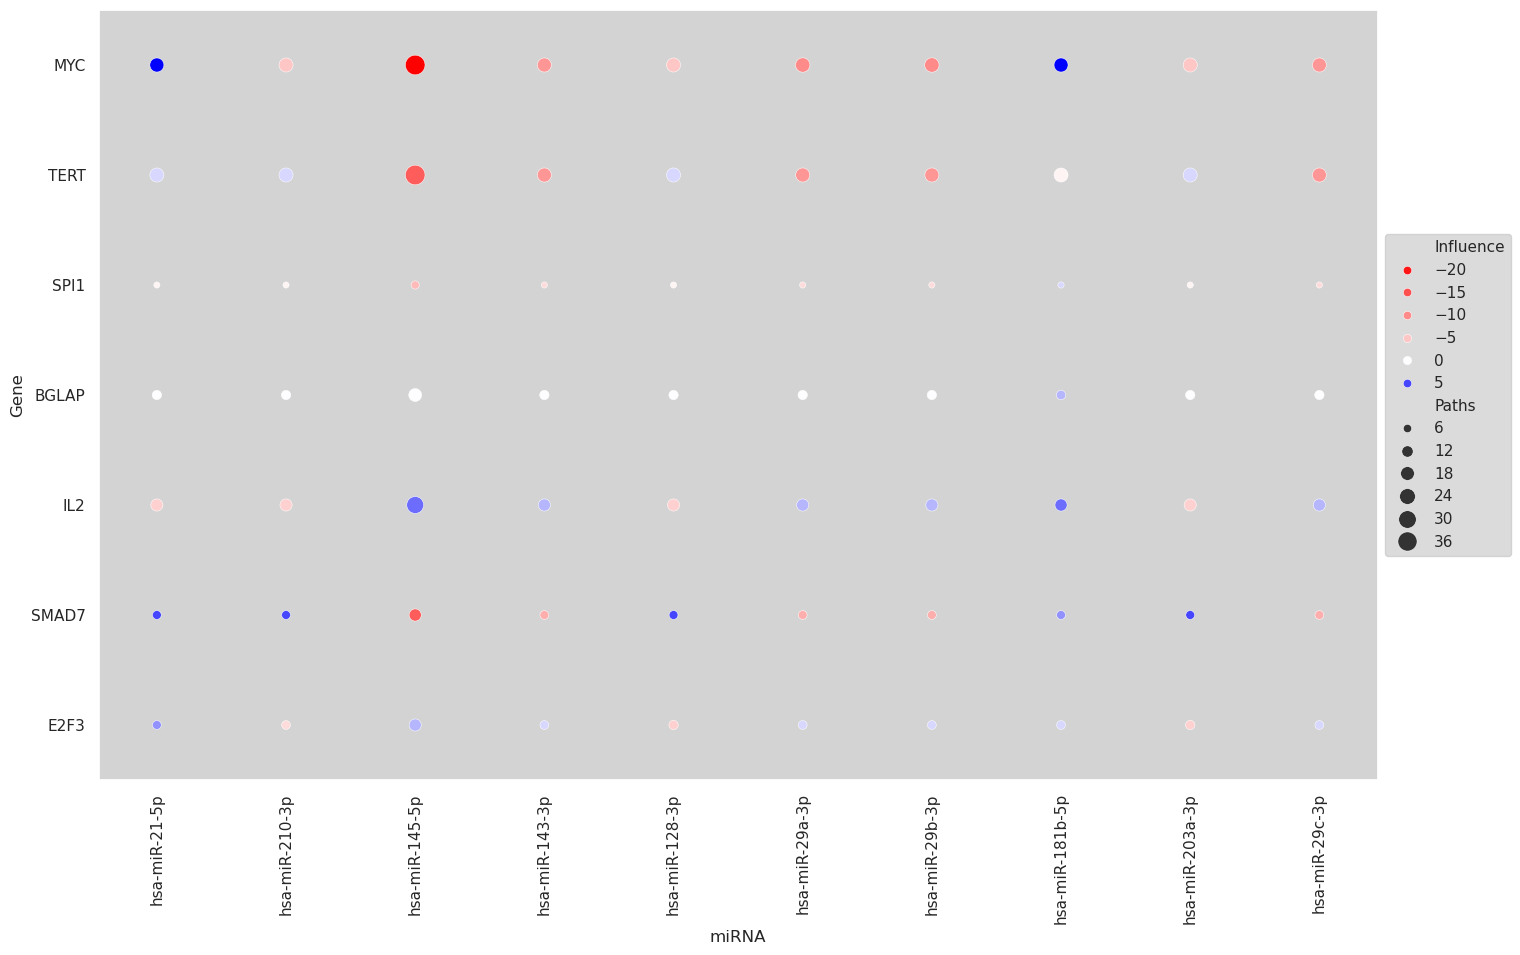

In [31]:
plot_dotplot((df.T[['MYC', 'TERT', 'SPI1','BGLAP','IL2', 'SMAD7', 'E2F3']]).T.iloc[:, : 10])

In [32]:
small_df = df.iloc[:3000, : 10]
order_df  = order_impact_mirna(df, 'hsa-miR-21-5p')


In [33]:
highest= order_df[:100]
lowest = order_df[-100:]
order_most_df=pd.concat([highest, lowest])

In [34]:
impact_most = get_impact_data(order_most_df)#.iloc[ : , :147])


In [35]:
impact_most

,hsa-miR-21-5p,hsa-miR-210-3p,hsa-miR-145-5p,hsa-miR-143-3p,hsa-miR-128-3p,hsa-miR-29a-3p,hsa-miR-29b-3p,hsa-miR-181b-5p,hsa-miR-203a-3p,hsa-miR-29c-3p,...,hsa-miR-19a-3p,hsa-miR-376c-3p,hsa-miR-199a-3p,hsa-miR-429,hsa-miR-126-3p,hsa-miR-200a-3p,hsa-miR-221-3p,hsa-miR-182-5p,hsa-miR-148a-3p,hsa-miR-103a-3p
BIRC5,10,0,-20,-10,0,-10,-10,8,-1,-10,...,0,0,-1,0,0,0,0,0,0,0
MMP1,10,2,-12,-6,2,-6,-6,6,2,-6,...,0,0,0,0,0,0,0,0,0,0
RELA,10,-2,-4,-2,-2,-2,-2,2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
HSPA1A,9,5,-18,-9,5,-9,-9,9,5,-9,...,0,0,0,0,0,0,0,0,0,0
NOX4,9,3,-14,-7,3,-7,-7,7,3,-7,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NR1I2,-7,-5,6,3,-5,3,3,-5,-5,3,...,0,0,0,0,0,0,0,0,-1,0
PDK4,-7,-9,6,3,-9,3,3,-3,-9,3,...,0,0,0,0,0,0,0,-1,0,0
BAX,-7,-3,10,5,-3,5,4,1,-5,5,...,0,0,0,0,0,0,0,0,-1,0
ESR1,-7,-11,10,3,-11,3,3,-3,-11,3,...,0,-1,0,0,0,0,-1,0,0,0


In [36]:
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import cityblock

df_numeric = impact_most.apply(pd.to_numeric, errors='coerce')

# Calculate the pairwise distances between columns
dist_matrix = pdist(df_numeric.T, metric='cityblock')
dist_matrix_square = squareform(dist_matrix)

# Create a DataFrame for the distance matrix
dist_df = pd.DataFrame(dist_matrix_square, index=df_numeric.columns, columns=df_numeric.columns)




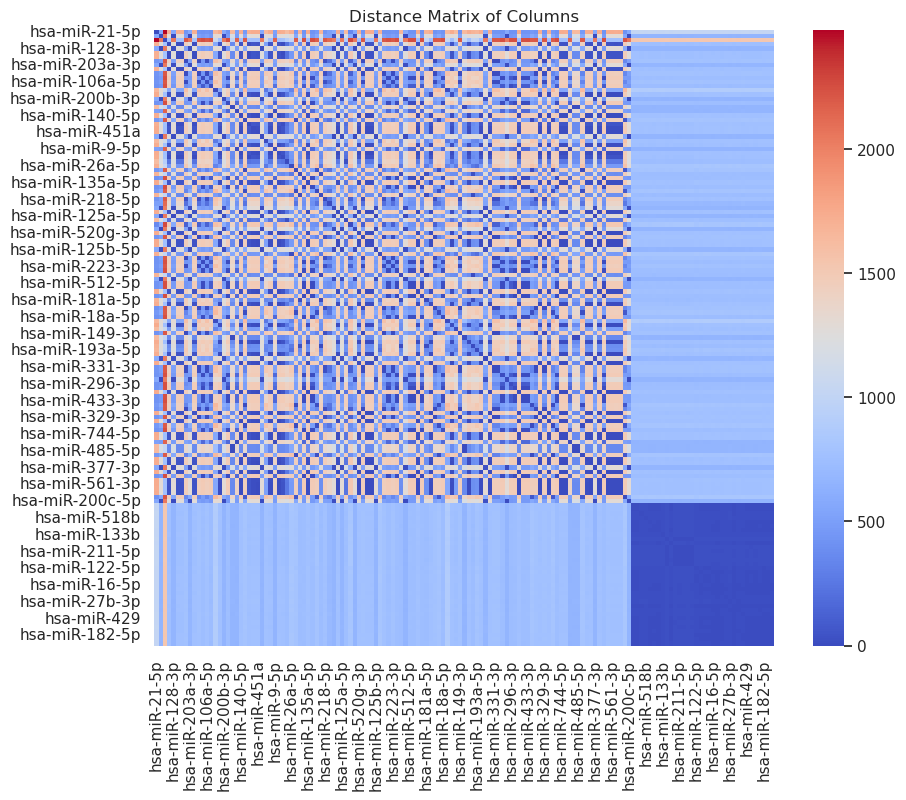

In [37]:
# Plotting the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(dist_df, annot=False, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Distance Matrix of Columns')
plt.show()

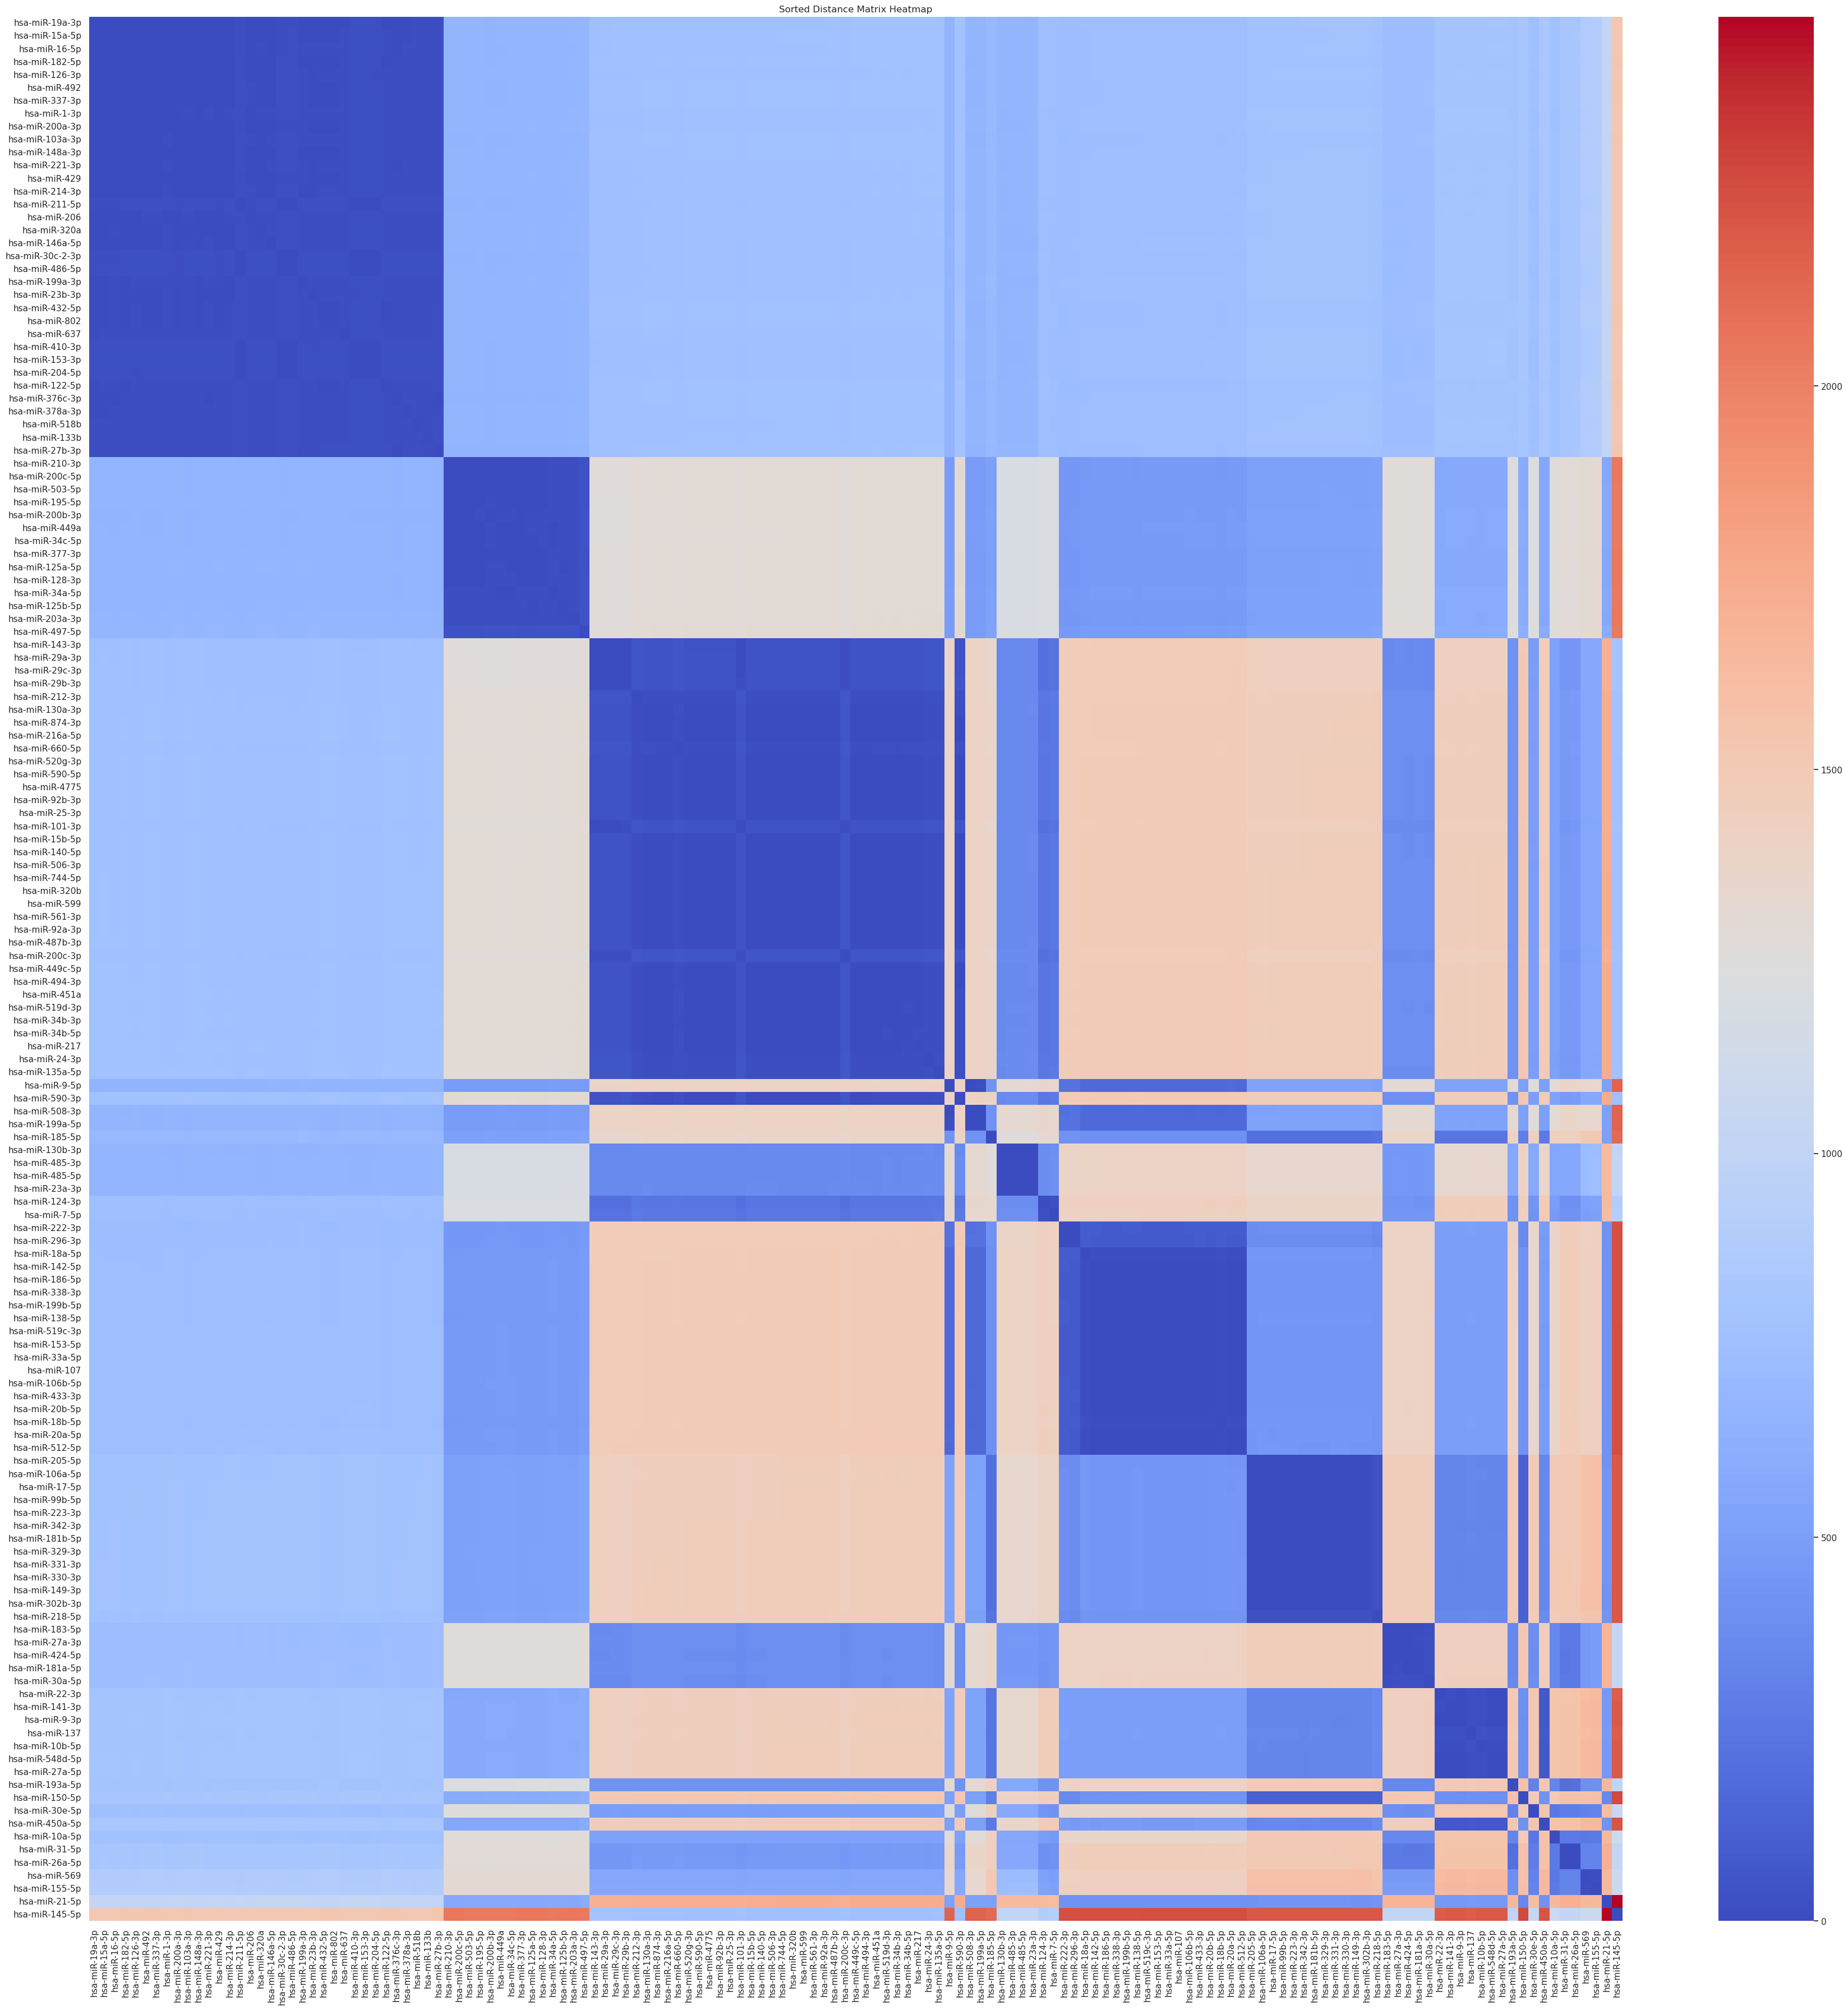

In [38]:
sorted_index = dist_df.mean().sort_values().index  # Sorting by mean distance

# Apply sorting to the DataFrame
sorted_df = dist_df.loc[sorted_index, sorted_index]

# Plot the sorted distance matrix as a heatmap
n_mirnas = len(sorted_df)
size_l = n_mirnas*0.3
plt.figure(figsize=(size_l, size_l))
sns.heatmap(sorted_df, annot=False, cmap='coolwarm')#, linewidths=0.5)#, linecolor='black')
plt.title('Sorted Distance Matrix Heatmap')
plt.show()

In [39]:
from sklearn.cluster import SpectralClustering

# Convert distance matrix to similarity matrix (affinity matrix)
affinity_matrix = np.exp(-dist_matrix_square / dist_matrix_square.std())  # Using Gaussian kernel for similarity

# Apply Spectral Clustering
n_clusters = 10  # Number of clusters
sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
cluster_labels = sc.fit_predict(affinity_matrix)


# Print cluster labels
print("Cluster labels:\n", cluster_labels)
mirnas = sorted_df.index

mirna_clusters  = pd.DataFrame(cluster_labels, index= mirnas, columns=['Cluster'])

Cluster labels:
 [2 7 1 1 7 1 1 5 7 1 5 2 5 2 3 1 7 2 6 9 1 4 1 1 1 7 3 1 9 1 1 1 3 4 8 2 1
 2 4 8 5 5 7 1 7 1 5 7 1 5 1 1 7 3 5 2 5 2 8 7 2 2 1 2 8 1 5 4 2 3 1 3 5 6
 1 8 3 1 7 1 5 5 2 7 2 2 1 2 2 4 5 1 5 1 4 2 1 1 9 6 6 4 1 1 7 1 2 1 1 1 1
 4 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [40]:
mirna_clusters[mirna_clusters['Cluster']>1].sort_values(by='Cluster')[:30]

,Cluster
hsa-miR-19a-3p,2
hsa-miR-146a-5p,2
hsa-miR-199a-5p,2
hsa-miR-508-3p,2
hsa-miR-130b-3p,2
hsa-miR-195-5p,2
hsa-miR-200c-5p,2
hsa-miR-485-3p,2
hsa-miR-216a-5p,2
hsa-miR-520g-3p,2


In [41]:
mirna_clusters.to_csv('mirna_cluster_effect.csv')

In [202]:
mirna_clusters.T

,hsa-miR-148a-3p,hsa-miR-16-5p,hsa-miR-15a-5p,hsa-miR-206,hsa-miR-378a-3p,hsa-miR-27b-3p,hsa-miR-19a-3p,hsa-miR-337-3p,hsa-miR-518b,hsa-miR-320a,...,hsa-miR-503-5p,hsa-miR-210-3p,hsa-miR-183-5p,hsa-miR-27a-3p,hsa-miR-30a-5p,hsa-miR-424-5p,hsa-miR-181a-5p,hsa-miR-508-3p,hsa-miR-199a-5p,hsa-miR-9-5p
Cluster,2,7,1,1,7,1,1,5,7,1,...,0,0,0,0,0,0,0,0,0,0


In [208]:
mirna_clusters.loc[['hsa-miR-21-5p','hsa-miR-16-5p','hsa-miR-145-5p', 'hsa-miR-210-3p', 'hsa-miR-27b-3p']]

,Cluster
hsa-miR-21-5p,7
hsa-miR-16-5p,7
hsa-miR-145-5p,2
hsa-miR-210-3p,0
hsa-miR-27b-3p,1


In [188]:
sorted_index

array([145, 132, 133, 134, 135, 136, 137, 113, 116, 117, 118, 119, 120,
       121, 114, 115, 124, 125, 126, 127, 128, 129, 122, 123, 146, 130,
       131, 138, 139, 140, 141, 142, 143, 144,  65,  22,  23,  93,  27,
        29,  30,  31,  91,  62,  24,  86,  70,  79, 107, 108, 109, 110,
        77,  74, 103,   9,  20,   6,  15,   5,   3,   2, 105,  36, 102,
        43,  45,  48,  50,  51,  97,  96,  87,  95,  88,  85,  84,  82,
         0,  57,  11,  13,  17,  35,  37,  55,  60,  63, 106,  61,  68,
        26,  76,  53,  14,  69,  71,  32,  38, 111,  21,  33, 101,  67,
        94,  89,   7,  90,  66,  92,  80,  81,  56,  72,  46,  54,  40,
        49,  10,  12,  41,  99,  18,  73, 100, 112,  47,  44,  78,  52,
        59,  42,  16,  25,   4,   8, 104,  83,   1,  39,  75,  34,  58,
        64,  98,  19,  28])

/home/karen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


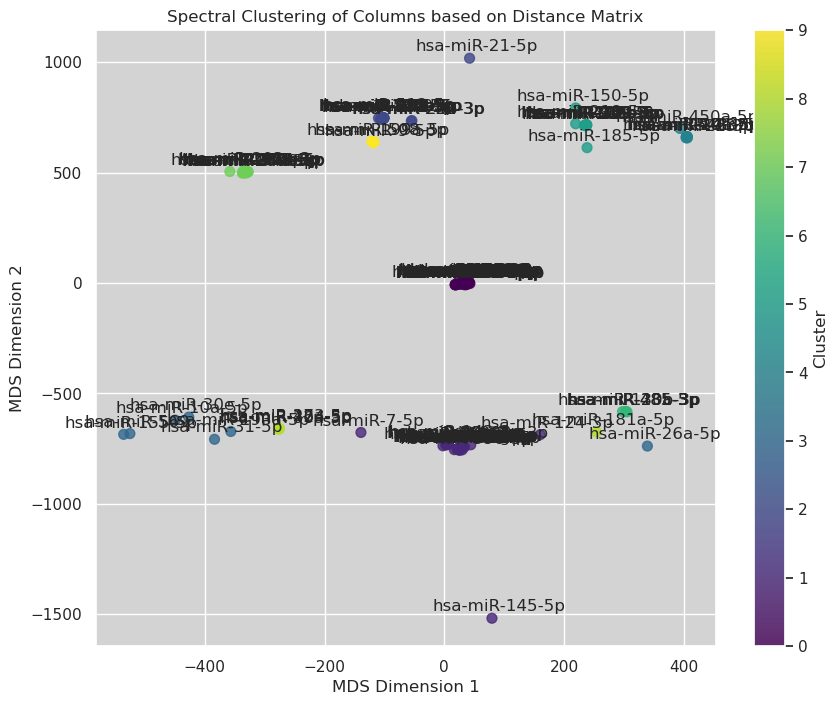

In [185]:
from sklearn.manifold import MDS

# Reduce dimensionality for visualization using Multi-Dimensional Scaling (MDS)

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
embedding = mds.fit_transform(dist_matrix_square)

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.8)

# Adding labels to the points
for i, txt in enumerate(df.columns):
    plt.annotate(txt, (embedding[i, 0], embedding[i, 1]), textcoords="offset points", xytext=(5,5), ha='center')

plt.colorbar(scatter, label='Cluster')
plt.title('Spectral Clustering of Columns based on Distance Matrix')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

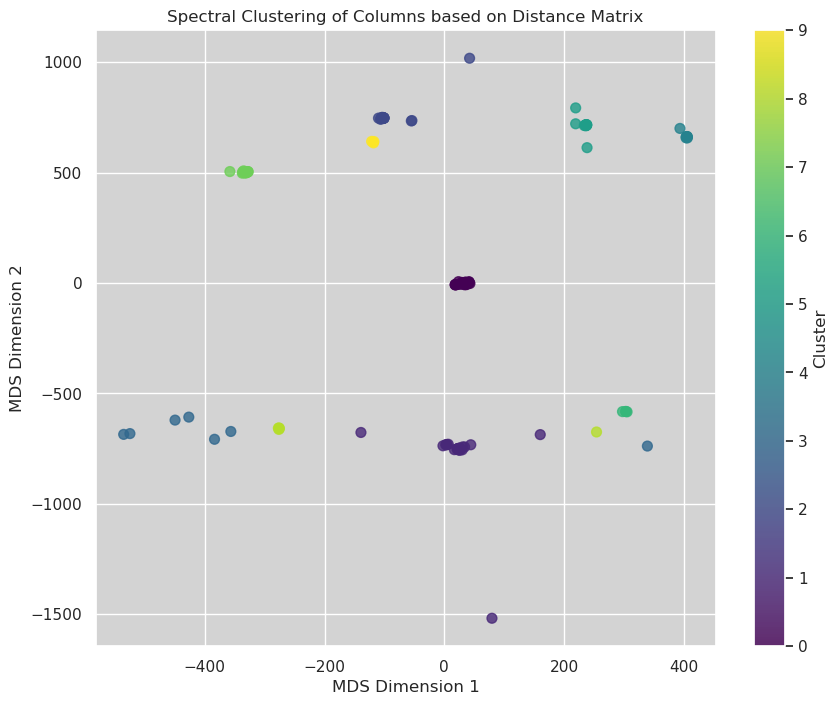

In [187]:
import mplcursors

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.8)

# Function to get labels for tooltips
def label_function(sel):
    index = sel.target.index
    sel.annotation.set_text(df.columns[index])

# Create the cursor
mplcursors.cursor(scatter).connect("add", label_function)

plt.colorbar(scatter, label='Cluster')
plt.title('Spectral Clustering of Columns based on Distance Matrix')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

In [124]:
order_impact_mirna(df, 'hsa-miR-21-5p').iloc[:50, -2: ]

,hsa-miR-148a-3p,hsa-miR-103a-3p
BIRC5,,
MMP1,,
RELA,,
HSPA1A,,
NOX4,,
IL6,,
CXCL8,,
CDK4,,
PENK,,
SLC2A4,,


In [72]:
df_sorted.iloc[:50, : ]

,hsa-miR-21-5p,hsa-miR-210-3p,hsa-miR-145-5p,hsa-miR-143-3p,hsa-miR-93-5p,hsa-miR-122-5p,hsa-miR-15a-5p,hsa-miR-375,hsa-miR-224-5p
TNFSF12,"[1, 1, 1, 1]","[1, 1, 1, 1]","[-1, -1, -1, -1, -1, -1, -1, -1]","[-1, -1, -1, -1]",,,,,
MYC,"[-1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1...","[-1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1,...","[-1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1,...","[-1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, ...",,,,,
TERT,"[-1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1...","[-1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1,...","[-1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1...","[-1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1...",,,,,
SPI1,"[-1, -1, 1]","[-1, -1, 1]","[-1, -1, -1, -1, -1, -1]","[-1, -1, -1]",,,,,
BGLAP,"[1, 1, 1, -1, -1, 1, -1, -1]","[-1, 1, 1, -1, 1, 1, -1, -1]","[1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, ...","[1, 1, -1, -1, 1, 1, -1, -1]",,,,,
STAT5A,"[-1, -1, 1, 1, -1, 1, 1]","[-1, -1, -1, -1, 1, 1, -1]","[1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1]","[1, 1, 1, 1, 1, -1, -1]",,,,,
IL2,"[-1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, ...","[-1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, ...","[-1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1]",,,,,
RELA,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-1, -1, -1, -1, -1, 1, 1, 1, 1, -1]","[1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1, 1, ...","[1, 1, 1, 1, -1, -1, -1, -1, -1, -1]",,,,,
FAS,"[-1, 1, 1, -1, 1, 1, -1, 1, 1, 1]","[-1, -1, -1, -1, -1, -1, -1, 1, 1, -1]","[1, 1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1...","[1, 1, -1, 1, -1, -1, -1, -1, -1, -1]",,,,,
IL3,"[-1, -1, -1, 1, 1, 1, 1, 1, 1, 1]","[-1, -1, 1, 1, 1, 1, 1, 1, -1, -1]","[1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1, 1, ...","[1, 1, 1, 1, -1, -1, -1, -1, -1, -1]",,,,,


In [60]:
df.head()

,hsa-miR-21-5p,hsa-miR-210-3p,hsa-miR-145-5p,hsa-miR-143-3p,hsa-miR-93-5p,hsa-miR-122-5p,hsa-miR-15a-5p,hsa-miR-375,hsa-miR-224-5p
MYC,"[-1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1...","[-1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1,...","[-1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1,...","[-1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, ...",,,,,
TERT,"[-1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1...","[-1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1,...","[-1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1...","[-1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1...",,,,,
SPI1,"[-1, -1, 1]","[-1, -1, 1]","[-1, -1, -1, -1, -1, -1]","[-1, -1, -1]",,,,,
BGLAP,"[1, 1, 1, -1, -1, 1, -1, -1]","[-1, 1, 1, -1, 1, 1, -1, -1]","[1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, ...","[1, 1, -1, -1, 1, 1, -1, -1]",,,,,
STAT5A,"[-1, -1, 1, 1, -1, 1, 1]","[-1, -1, -1, -1, 1, 1, -1]","[1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1]","[1, 1, 1, 1, 1, -1, -1]",,,,,


In [32]:
df.index

Index(['MYC', 'TERT', 'SPI1', 'BGLAP', 'STAT5A', 'IL2', 'RELA', 'FAS', 'IL3',
       'STAT1',
       ...
       'CD59', 'IFNL2', 'EIF5A', 'DEFB124', 'KCNA4', 'LAMC1', 'ESAM', 'ITGA2',
       'PEG3', 'TNFSF12'],
      dtype='object', length=3456)

250


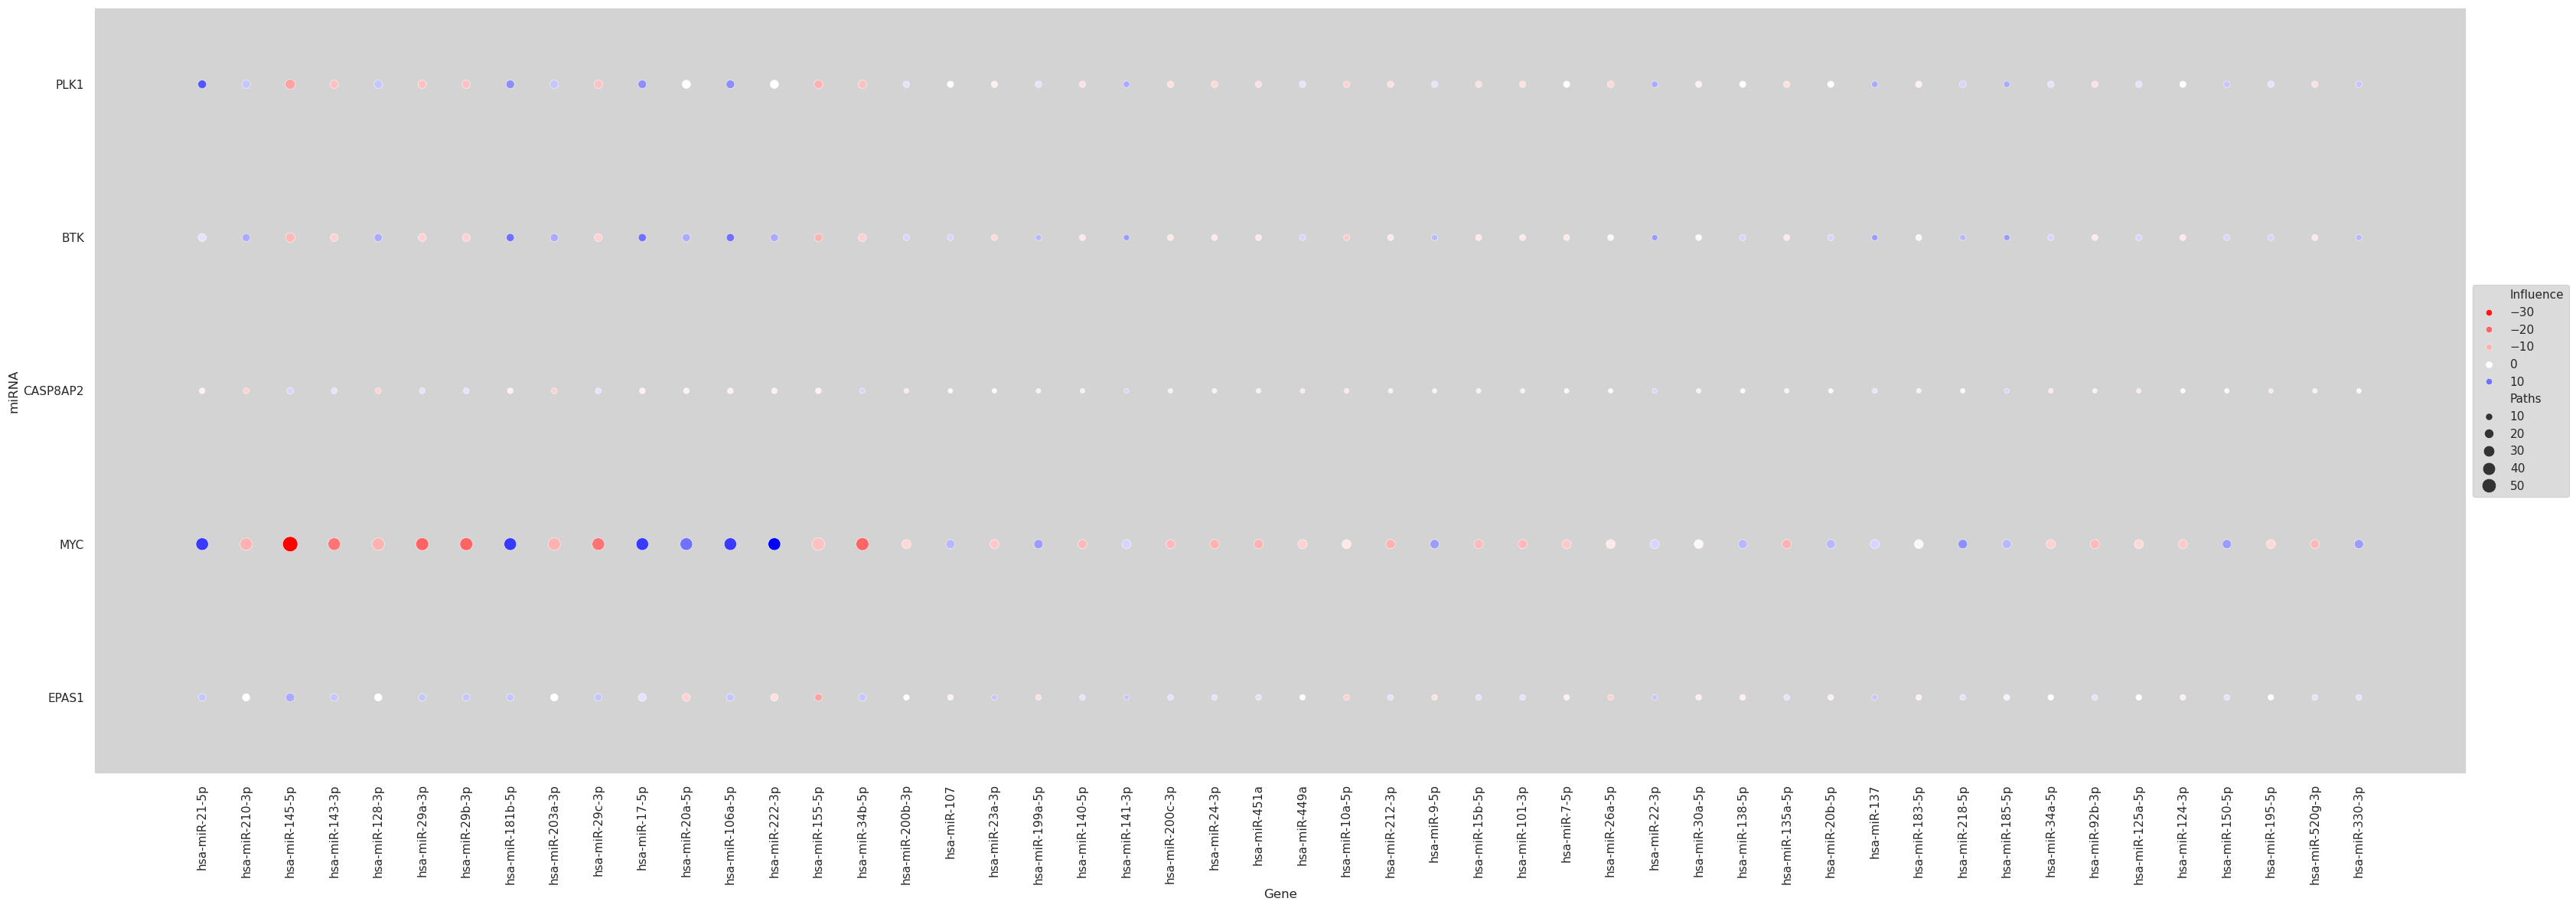

In [59]:
mini_df = df[df.index.isin(['PLK1',  'BTK', 'CASP8AP2','MYC', 'EPAS1'])]
desired_order = ['PLK1', 'BTK', 'CASP8AP2','MYC', 'EPAS1']
mini_df = mini_df.reindex(desired_order)
mini_df = mini_df.iloc[:, : 50]
plot_dotplot(mini_df)

This is the "next section"! 

### Up or down reculated

#### Young vs Old

See the influcne of the genes that are down regualted in Young respect to old, this means that they INCREASE WITH AGE.
Therefore, what we would like to see is more big red dots that means that the microRNA inhibits that gene.

Get the up or down reluation


This are only the 1381 genes that are down regulated and then the 589 genes that are up regulated

In [34]:
regulation_YO={}
up_regulation_YO={}
down_regulation_YO={}
for node_name in whole_network.nodes:
    node = whole_network.nodes[node_name]
    if 'yo' in node['data']:
        regulation = node['data']['yo']
        regulation_YO[node['data']['name']]=regulation
        if regulation>0:
            up_regulation_YO[node['data']['name']]=regulation
        elif regulation<0:
            down_regulation_YO[node['data']['name']]=regulation


In [35]:
df_de_yo = df[df.index.isin(regulation_YO.keys())]
df_down_yo = df[df.index.isin(down_regulation_YO.keys())]
df_up_yo = df[df.index.isin(up_regulation_YO.keys())]

In [ ]:
plot_dotplot(df_down_yo.iloc[:, : 20])

In [ ]:
df_down_yo.iloc[:, : 20]

See the influcne of the genes that are up regualted in Young respect to old, this means that they DECREASED WITH AGE.
Therefore, what we would like to see is more big blue dots that means that the microRNA estimulate that gene.

In [ ]:
plot_dotplot(df_up_yo)

#### Young vs Middle age

In [38]:
regulation_YM={}
up_regulation_YM={}
down_regulation_YM={}
for node_name in whole_network.nodes:
    node = whole_network.nodes[node_name]
    if 'ym' in node['data']:
        regulation = node['data']['ym']
        regulation_YM[node['data']['name']]=regulation
        if regulation>0:
            up_regulation_YM[node['data']['name']]=regulation
        elif regulation<0:
            down_regulation_YM[node['data']['name']]=regulation


In [39]:
df_de_ym = df[df.index.isin(regulation_YM.keys())]
df_down_ym = df[df.index.isin(down_regulation_YM.keys())]
df_up_ym = df[df.index.isin(up_regulation_YM.keys())]

Down regulated in young respect of middle age

In [ ]:
plot_dotplot(df_down_ym)

Up regulated in young respect of middle age

In [ ]:
plot_dotplot(df_up_ym)

#### Middle age vs Old

In [42]:
regulation_MO={}
up_regulation_MO={}
down_regulation_MO={}
for node_name in whole_network.nodes:
    node = whole_network.nodes[node_name]
    if 'mo' in node['data']:
        regulation = node['data']['mo']
        regulation_MO[node['data']['name']]=regulation
        if regulation>0:
            up_regulation_MO[node['data']['name']]=regulation
        elif regulation<0:
            down_regulation_MO[node['data']['name']]=regulation



In [43]:
df_down_mo = df[df.index.isin(down_regulation_MO.keys())]
df_up_mo = df[df.index.isin(up_regulation_MO.keys())]


These are the genes down regulated in middle age vs Old, this is the genes that increase with age.

In [ ]:
plot_dotplot(df_down_mo)

These are the genes up regulated in middle age vs Old, this is the genes that decrease with age... oh, there were not.

### Pathways affected

Now, usig those 13 microRNA nodes in the whole network, we start on that mirna and do on 5 steps, 10 paths, doing that we registered the paths that the path visits (I am still working on how to describe this with words) 
But basically we have record of all the pathways genes alterated. 

In [45]:
mirPaths={}
for mir in miR_nodes:
    p = wn.get_pathways(graph=whole_network, mirna=mir, n_distance=steps, sample_size=10)
    unique_set = set(tuple(lst) for lst in p)
    
    # Convert back to a list of lists
    unique_list = [list(tpl) for tpl in unique_set]
    mirPaths[mir]=unique_list


In [ ]:
mirPaths

In [47]:
mirInfluence={}
for mir, path in mirPaths.items():
    influence = wn.get_influence(whole_network, path)
    mirInfluence[mir]=influence
#mirInfluence

In [48]:
mir_pathway_influence = {}
for mir, influence_data in  mirInfluence.items():
    pi = wn.evaluate_pathway_influence(influence_data)
    mir_pathway_influence[mir]=pi

mir_de_influence = {}
for mir, influence_data in  mirInfluence.items():
    pi = wn.evaluate_de_influence(influence_data)
    mir_de_influence[mir]=pi


We recoreded the times it gets on a gene on that pathway. There are registered on the table bellow. Since there are many pathways that we don't consider, there is a column called Different_pathways that shows the unique pathways the mirna affected somehow on those 5 steps, Total is the sum of all (considerered or not) and participation is the sum of those that are considered.

In [49]:
mir_pathway_influence_df = pd.DataFrame(mir_pathway_influence).T
#mir_pathway_influence_df = mir_pathway_influence_df.drop(columns=["Different_pathways", "Total"])
mir_pathway_influence_df['participation'] = mir_pathway_influence_df.drop(columns=["Different_pathways", "Total"]).sum(axis=1)
mir_pathway_influence_df

,ATP,MITOCHONDRI,RESPIRAT,METABOLI,OXIDATIVE_PHOSPHORYLATION,NONALCOHOLIC_FATTY_LIVER,MUSCLE,ELECTRON,Different_pathways,Total,participation
hsa-miR-223,0,0,0,0,0,0,0,0,0,0,0
hsa-miR-21-5p,0,0,2,1,1,0,1,0,14,120,5
hsa-miR-210-3p,0,0,0,0,0,1,1,0,6,56,2
hsa-miR-122,0,0,0,0,0,0,0,0,0,0,0
hsa-miR-145-5p,0,1,0,5,0,0,1,0,9,152,7
...,...,...,...,...,...,...,...,...,...,...,...
hsa-miR-1283,0,0,0,0,0,1,0,0,2,16,1
hsa-miR-335-3p,0,0,0,0,0,0,0,0,0,0,0
hsa-miR-195-3p,0,0,0,0,0,0,0,0,0,0,0
hsa-miR-204-3p,0,0,0,0,0,0,0,0,0,0,0


And here is the same data but on a heatmap. The most... brown(?) is the more times it land on that pathway.

<Axes: >

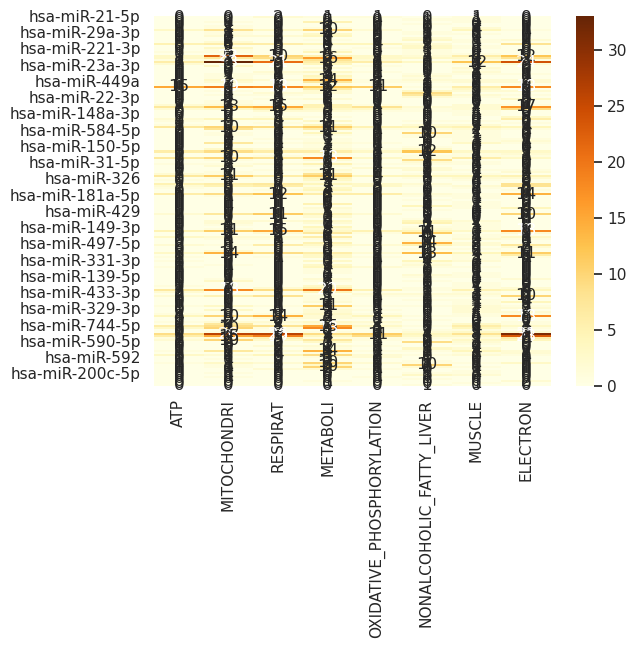

In [50]:
mir_pathway_influence_df_n0=mir_pathway_influence_df[mir_pathway_influence_df['participation']>0]
mir_pathway_influence_df_n0 = mir_pathway_influence_df_n0.drop(columns=["Different_pathways", "Total", "participation"])

sns.heatmap(mir_pathway_influence_df_n0, cmap="YlOrBr", annot=True)

### Mirnas that affect differential expressed genes



Some micrornas, on that 5 step path, affect DE genes on Young vs Old, Young vs Middle Age and Middle age vs Old. 

In [51]:
mir_de_influence_df = pd.DataFrame(mir_de_influence).T


Here are the mirnas que affect DE genes and how many of those genes it affects. 

In [52]:
mirs_all_infliences = mir_de_influence_df[(mir_de_influence_df['ym']>0)|(mir_de_influence_df['mo']>0)|(mir_de_influence_df['yo']>0)]
mirs_all_infliences

,m_l,m_s,yo,ym,mo
hsa-miR-21-5p,0,0,8,1,3
hsa-miR-210-3p,0,0,6,0,2
hsa-miR-145-5p,0,0,8,1,5
hsa-miR-224-5p,0,0,1,0,0
hsa-miR-93-5p,0,0,2,0,0
...,...,...,...,...,...
hsa-miR-515-5p,0,0,1,0,0
hsa-miR-301b-5p,0,0,1,0,1
hsa-miR-922,0,0,1,0,0
hsa-miR-144-5p,0,0,1,0,0
